In [4]:
%matplotlib inline
import autorootcwd
from src.segment_anything import sam_model_registry
from src.utils.demo import BboxPromptDemo
import torch

MedSAM_CKPT_PATH = "weights/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

/home/kanghyun/brats-segment-anything/src/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.devi

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
import numpy as np
from skimage.transform import resize

# Load the numpy file
data = np.load('demo/test_demo/imgs/3DBox_MR_demo.npz')
image = data['imgs'][36]
print(f"Original image shape: {image.shape}")

# Resize the image to 1024x1024
resized_image = resize(image, (1024, 1024), order=1, preserve_range=True)

# Normalize the image to [0, 1]
normalized_image = (resized_image - resized_image.min()) / (resized_image.max() - resized_image.min())
three_channel_image = np.repeat(normalized_image[np.newaxis], 3, axis=0)

# Add batch and channel dimensions, and move to device
input_image = torch.from_numpy(three_channel_image).unsqueeze(0).float().to(device)
print(f"Input image shape: {input_image.shape}")

# Pass the image through the encoder
out = medsam_model.image_encoder(input_image)

print(f"Encoder output shape: {out.shape}")

Original image shape: (240, 240)
Input image shape: torch.Size([1, 3, 1024, 1024])
Encoder output shape: torch.Size([1, 256, 64, 64])


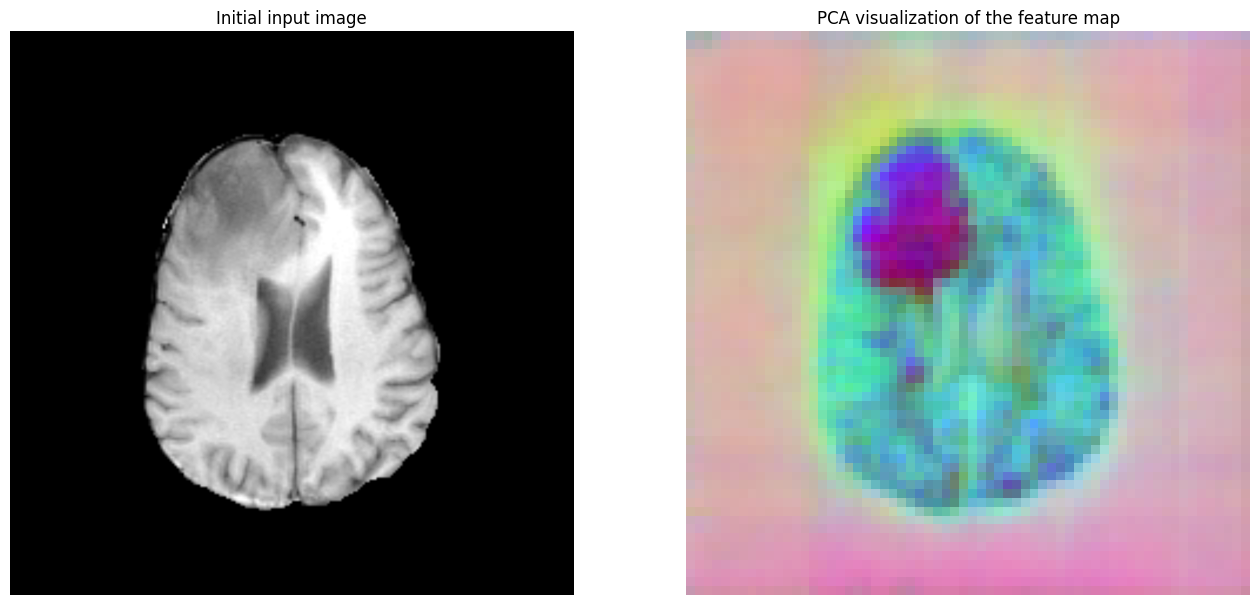

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'out' is your encoder output with shape [1, 256, 64, 64]
# Extract the feature map and reshape it
feature_map = out[0].detach().cpu().numpy()  # Shape: [256, 64, 64]
feature_map_reshaped = feature_map.reshape(256, -1).T  # Shape: [4096, 256]

# Apply PCA
pca = PCA(n_components=3)
feature_map_pca = pca.fit_transform(feature_map_reshaped)

# Reshape back to image dimensions
feature_map_pca = feature_map_pca.reshape(64, 64, 3)

# Normalize to [0, 1] for visualization
feature_map_pca_normalized = (feature_map_pca - feature_map_pca.min()) / (feature_map_pca.max() - feature_map_pca.min())

# Plot the PCA visualization
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(input_image[0,0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Initial input image')
plt.subplot(1, 2, 2)
plt.imshow(feature_map_pca_normalized, cmap='jet')
plt.axis('off')
plt.title('PCA visualization of the feature map')
plt.savefig('input_image.png', bbox_inches='tight', pad_inches=0)




In [21]:
positional_encoding = medsam_model.prompt_encoder.get_dense_pe()

In [22]:
positional_encoding.shape

torch.Size([1, 256, 64, 64])

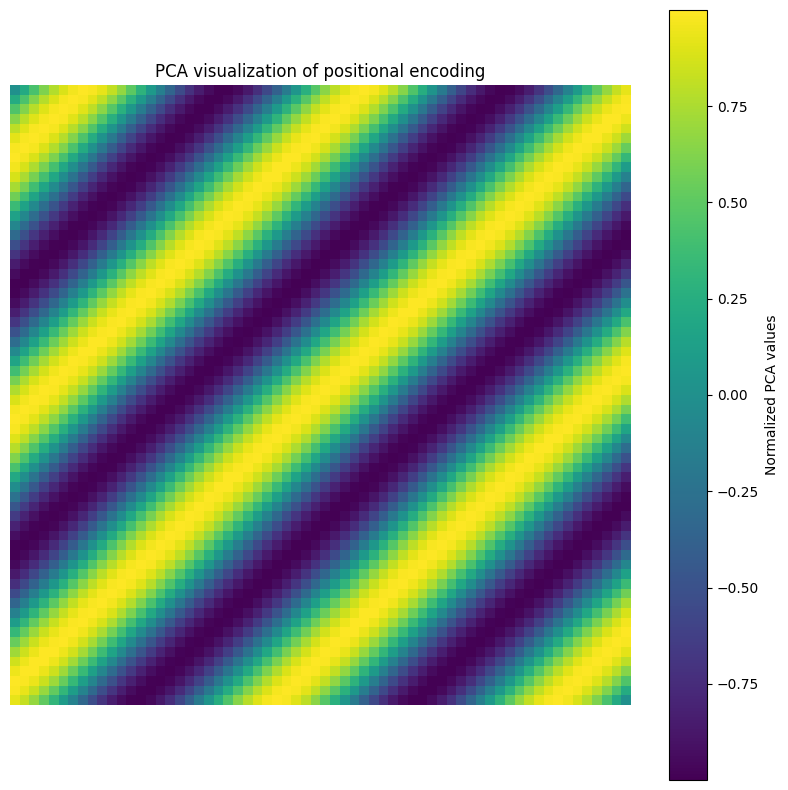

Explained variance ratio: [0.05221283 0.04846255 0.04486367]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert positional encoding to numpy array and reshape
pe = positional_encoding[0].detach().cpu().numpy()  # Shape: [256, 64, 64]
# Plot the PCA visualization
plt.figure(figsize=(10, 10))
plt.imshow(pe[200])
plt.axis('off')
plt.title('PCA visualization of positional encoding')
plt.colorbar(label='Normalized PCA values')
plt.savefig('positional_encoding_visualization.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)